As I am using google colab for model building, connecting colab session with gdrive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Checking if the path is correct

In [2]:
import os
path= '/content/drive/MyDrive/Colab Notebooks/NLP_tranformers/data_clean.csv'
print(os.path.isfile(path))

True


In [3]:
import tensorflow as tf
tf.enable_eager_execution()

In [37]:
import pandas as pd
df = pd.read_csv(path)
df = df[['text','label']]
df['text'] = df['text'].replace('\n',' ', regex=True)
df.rename(columns={'text': 'article', 'label': 'category'}, inplace=True)
df.head()

,article,category
0,ad sales boost time warner profit quarterly p...,business
1,dollar gains on greenspan speech the dollar h...,business
2,yukos unit buyer faces loan claim the owners ...,business
3,high fuel prices hit ba's profits british air...,business
4,pernod takeover talk lifts domecq shares in u...,business


In [38]:
df['category'].value_counts()

business         495
sport            495
politics         403
entertainment    378
tech             342
Name: category, dtype: int64

Encoding the categorical targets and creating a new column with encoded values

In [39]:
possible_labels = df.category.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}

In [40]:
df['label'] = df.category.replace(label_dict)
df['label'].value_counts()

3    495
0    495
2    403
1    378
4    342
Name: label, dtype: int64

Data splitting

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.index.values, 
                                                  df.label.values, 
                                                  test_size= 0.2, 
                                                  random_state=100, 
                                                  stratify=df.label.values)

df['data_type'] = ['not_set']*df.shape[0]

df.loc[X_train, 'data_type'] = 'train'
df.loc[X_test, 'data_type'] = 'test'

df.groupby(['category', 'label', 'data_type']).count()

article
category      label data_type         
business      0     test            99
                    train          396
entertainment 1     test            76
                    train          302
politics      2     test            81
                    train          322
sport         3     test            99
                    train          396
tech          4     test            68
                    train          274

In [42]:
train, test =  train_test_split(df, test_size = 0.2, random_state = 100,stratify=df.label.values)

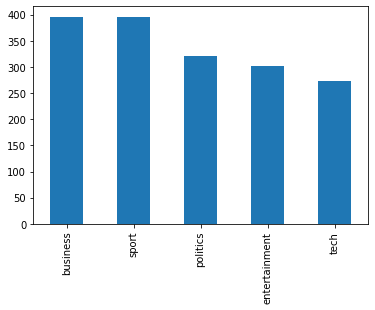

In [14]:
train['category'].value_counts().plot(kind = 'bar')

In [10]:
train.head()

,article,category,label,data_type
2108,broadband fuels online expression fast web ac...,tech,4,train
517,famed music director viotti dies conductor ma...,entertainment,1,train
888,crisis 'ahead in social sciences' a national ...,politics,2,train
626,sir paul rocks super bowl crowds sir paul mcc...,entertainment,1,train
978,howard attacks cost of asylum michael howard ...,politics,2,train


In [14]:
test.head()

,article,category,label,data_type
646,outkast win at mtv europe awards us hip-hop d...,entertainment,1,test
1734,faultless federer has no equal roger federer ...,sport,3,test
830,us composer recreates bach score a us musicol...,entertainment,1,test
542,'landmark movies' of 2004 hailed us film prof...,entertainment,1,test
1268,tories urge 'change at the top' tory delegate...,politics,2,test


Data preprcessing using pretrained transformer architectures (BERT) from tensorflow hub

In [10]:
import numpy as np

#import keras
#import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
import logging
logging.basicConfig(level=logging.INFO)

In [11]:
!wget --quiet https://raw.githubusercontent.com/google-research/bert/master/tokenization.py
!pip install sentencepiece

In [ ]:
#importing tokenization class from bert official library and other dependencies
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 5.3 MB/s 


In [19]:
!pip install tensorflow==1.15.0

     |████████████████████████████████| 412.3 MB 25 kB/s 
     |████████████████████████████████| 3.8 MB 43.0 MB/s 
     |████████████████████████████████| 50 kB 4.7 MB/s 
     |████████████████████████████████| 503 kB 17.7 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=b049f7a7a7878640f29eb78355386654ebd9bb2d7d057d42be853ee74b47ea96
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.7.0
    Uninstalling tensorflow-estimator-2.7.0:
      Successfully uninstalled tensorflow-estimator-2.7.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.7.0
    Uninstalling tensorboard-2.7.0:
      Successfully uninstalled tensorboard-2.7.0
  Attempting uninstall: gast
    Found existing installation: gast 0.4.0
    Uninstalling gast-0.4.0:
      Succes

In [12]:
import tokenization

We will now start with the pretrained BERT. In this case we will use the bert_uncased_L-12_H-768_A-12/2 model. We will be using the vocab.txt file in the model to map the words in the dataset to indexes. Also the loaded BERT model is trained on uncased/lowercase data and hence the data we feed to train the model should also be of lowercase.

The following code block loads the pre-trained BERT model and initializers a tokenizer object for tokenizing the texts.

In [4]:
print(tf. __version__) 

1.15.0


In [13]:
# coding=utf-8
# Copyright 2018 The Google AI Language Team Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
"""Tokenization classes."""

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import re
import unicodedata
import six
import tensorflow as tf


def validate_case_matches_checkpoint(do_lower_case, init_checkpoint):
  """Checks whether the casing config is consistent with the checkpoint name."""

  # The casing has to be passed in by the user and there is no explicit check
  # as to whether it matches the checkpoint. The casing information probably
  # should have been stored in the bert_config.json file, but it's not, so
  # we have to heuristically detect it to validate.

  if not init_checkpoint:
    return

  m = re.match("^.*?([A-Za-z0-9_-]+)/bert_model.ckpt", init_checkpoint)
  if m is None:
    return

  model_name = m.group(1)

  lower_models = [
      "uncased_L-24_H-1024_A-16", "uncased_L-12_H-768_A-12",
      "multilingual_L-12_H-768_A-12", "chinese_L-12_H-768_A-12"
  ]

  cased_models = [
      "cased_L-12_H-768_A-12", "cased_L-24_H-1024_A-16",
      "multi_cased_L-12_H-768_A-12"
  ]

  is_bad_config = False
  if model_name in lower_models and not do_lower_case:
    is_bad_config = True
    actual_flag = "False"
    case_name = "lowercased"
    opposite_flag = "True"

  if model_name in cased_models and do_lower_case:
    is_bad_config = True
    actual_flag = "True"
    case_name = "cased"
    opposite_flag = "False"

  if is_bad_config:
    raise ValueError(
        "You passed in `--do_lower_case=%s` with `--init_checkpoint=%s`. "
        "However, `%s` seems to be a %s model, so you "
        "should pass in `--do_lower_case=%s` so that the fine-tuning matches "
        "how the model was pre-training. If this error is wrong, please "
        "just comment out this check." % (actual_flag, init_checkpoint,
                                          model_name, case_name, opposite_flag))


def convert_to_unicode(text):
  """Converts `text` to Unicode (if it's not already), assuming utf-8 input."""
  if six.PY3:
    if isinstance(text, str):
      return text
    elif isinstance(text, bytes):
      return text.decode("utf-8", "ignore")
    else:
      raise ValueError("Unsupported string type: %s" % (type(text)))
  elif six.PY2:
    if isinstance(text, str):
      return text.decode("utf-8", "ignore")
    elif isinstance(text, unicode):
      return text
    else:
      raise ValueError("Unsupported string type: %s" % (type(text)))
  else:
    raise ValueError("Not running on Python2 or Python 3?")


def printable_text(text):
  """Returns text encoded in a way suitable for print or `tf.logging`."""

  # These functions want `str` for both Python2 and Python3, but in one case
  # it's a Unicode string and in the other it's a byte string.
  if six.PY3:
    if isinstance(text, str):
      return text
    elif isinstance(text, bytes):
      return text.decode("utf-8", "ignore")
    else:
      raise ValueError("Unsupported string type: %s" % (type(text)))
  elif six.PY2:
    if isinstance(text, str):
      return text
    elif isinstance(text, unicode):
      return text.encode("utf-8")
    else:
      raise ValueError("Unsupported string type: %s" % (type(text)))
  else:
    raise ValueError("Not running on Python2 or Python 3?")


def load_vocab(vocab_file):
  """Loads a vocabulary file into a dictionary."""
  vocab = collections.OrderedDict()
  index = 0
  with tf.io.gfile.GFile(vocab_file, "r") as reader:
    while True:
      token = convert_to_unicode(reader.readline())
      if not token:
        break
      token = token.strip()
      vocab[token] = index
      index += 1
  return vocab


def convert_by_vocab(vocab, items):
  """Converts a sequence of [tokens|ids] using the vocab."""
  output = []
  for item in items:
    output.append(vocab[item])
  return output


def convert_tokens_to_ids(vocab, tokens):
  return convert_by_vocab(vocab, tokens)


def convert_ids_to_tokens(inv_vocab, ids):
  return convert_by_vocab(inv_vocab, ids)


def whitespace_tokenize(text):
  """Runs basic whitespace cleaning and splitting on a piece of text."""
  text = text.strip()
  if not text:
    return []
  tokens = text.split()
  return tokens


class FullTokenizer(object):
  """Runs end-to-end tokenziation."""

  def __init__(self, vocab_file, do_lower_case=True):
    self.vocab = load_vocab(vocab_file)
    self.inv_vocab = {v: k for k, v in self.vocab.items()}
    self.basic_tokenizer = BasicTokenizer(do_lower_case=do_lower_case)
    self.wordpiece_tokenizer = WordpieceTokenizer(vocab=self.vocab)

  def tokenize(self, text):
    split_tokens = []
    for token in self.basic_tokenizer.tokenize(text):
      for sub_token in self.wordpiece_tokenizer.tokenize(token):
        split_tokens.append(sub_token)

    return split_tokens

  def convert_tokens_to_ids(self, tokens):
    return convert_by_vocab(self.vocab, tokens)

  def convert_ids_to_tokens(self, ids):
    return convert_by_vocab(self.inv_vocab, ids)


class BasicTokenizer(object):
  """Runs basic tokenization (punctuation splitting, lower casing, etc.)."""

  def __init__(self, do_lower_case=True):
    """Constructs a BasicTokenizer.

    Args:
      do_lower_case: Whether to lower case the input.
    """
    self.do_lower_case = do_lower_case

  def tokenize(self, text):
    """Tokenizes a piece of text."""
    text = convert_to_unicode(text)
    text = self._clean_text(text)

    # This was added on November 1st, 2018 for the multilingual and Chinese
    # models. This is also applied to the English models now, but it doesn't
    # matter since the English models were not trained on any Chinese data
    # and generally don't have any Chinese data in them (there are Chinese
    # characters in the vocabulary because Wikipedia does have some Chinese
    # words in the English Wikipedia.).
    text = self._tokenize_chinese_chars(text)

    orig_tokens = whitespace_tokenize(text)
    split_tokens = []
    for token in orig_tokens:
      if self.do_lower_case:
        token = token.lower()
        token = self._run_strip_accents(token)
      split_tokens.extend(self._run_split_on_punc(token))

    output_tokens = whitespace_tokenize(" ".join(split_tokens))
    return output_tokens

  def _run_strip_accents(self, text):
    """Strips accents from a piece of text."""
    text = unicodedata.normalize("NFD", text)
    output = []
    for char in text:
      cat = unicodedata.category(char)
      if cat == "Mn":
        continue
      output.append(char)
    return "".join(output)

  def _run_split_on_punc(self, text):
    """Splits punctuation on a piece of text."""
    chars = list(text)
    i = 0
    start_new_word = True
    output = []
    while i < len(chars):
      char = chars[i]
      if _is_punctuation(char):
        output.append([char])
        start_new_word = True
      else:
        if start_new_word:
          output.append([])
        start_new_word = False
        output[-1].append(char)
      i += 1

    return ["".join(x) for x in output]

  def _tokenize_chinese_chars(self, text):
    """Adds whitespace around any CJK character."""
    output = []
    for char in text:
      cp = ord(char)
      if self._is_chinese_char(cp):
        output.append(" ")
        output.append(char)
        output.append(" ")
      else:
        output.append(char)
    return "".join(output)

  def _is_chinese_char(self, cp):
    """Checks whether CP is the codepoint of a CJK character."""
    # This defines a "chinese character" as anything in the CJK Unicode block:
    #   https://en.wikipedia.org/wiki/CJK_Unified_Ideographs_(Unicode_block)
    #
    # Note that the CJK Unicode block is NOT all Japanese and Korean characters,
    # despite its name. The modern Korean Hangul alphabet is a different block,
    # as is Japanese Hiragana and Katakana. Those alphabets are used to write
    # space-separated words, so they are not treated specially and handled
    # like the all of the other languages.
    if ((cp >= 0x4E00 and cp <= 0x9FFF) or  #
        (cp >= 0x3400 and cp <= 0x4DBF) or  #
        (cp >= 0x20000 and cp <= 0x2A6DF) or  #
        (cp >= 0x2A700 and cp <= 0x2B73F) or  #
        (cp >= 0x2B740 and cp <= 0x2B81F) or  #
        (cp >= 0x2B820 and cp <= 0x2CEAF) or
        (cp >= 0xF900 and cp <= 0xFAFF) or  #
        (cp >= 0x2F800 and cp <= 0x2FA1F)):  #
      return True

    return False

  def _clean_text(self, text):
    """Performs invalid character removal and whitespace cleanup on text."""
    output = []
    for char in text:
      cp = ord(char)
      if cp == 0 or cp == 0xfffd or _is_control(char):
        continue
      if _is_whitespace(char):
        output.append(" ")
      else:
        output.append(char)
    return "".join(output)


class WordpieceTokenizer(object):
  """Runs WordPiece tokenziation."""

  def __init__(self, vocab, unk_token="[UNK]", max_input_chars_per_word=200):
    self.vocab = vocab
    self.unk_token = unk_token
    self.max_input_chars_per_word = max_input_chars_per_word

  def tokenize(self, text):
    """Tokenizes a piece of text into its word pieces.

    This uses a greedy longest-match-first algorithm to perform tokenization
    using the given vocabulary.

    For example:
      input = "unaffable"
      output = ["un", "##aff", "##able"]

    Args:
      text: A single token or whitespace separated tokens. This should have
        already been passed through `BasicTokenizer.

    Returns:
      A list of wordpiece tokens.
    """

    text = convert_to_unicode(text)

    output_tokens = []
    for token in whitespace_tokenize(text):
      chars = list(token)
      if len(chars) > self.max_input_chars_per_word:
        output_tokens.append(self.unk_token)
        continue

      is_bad = False
      start = 0
      sub_tokens = []
      while start < len(chars):
        end = len(chars)
        cur_substr = None
        while start < end:
          substr = "".join(chars[start:end])
          if start > 0:
            substr = "##" + substr
          if substr in self.vocab:
            cur_substr = substr
            break
          end -= 1
        if cur_substr is None:
          is_bad = True
          break
        sub_tokens.append(cur_substr)
        start = end

      if is_bad:
        output_tokens.append(self.unk_token)
      else:
        output_tokens.extend(sub_tokens)
    return output_tokens


def _is_whitespace(char):
  """Checks whether `chars` is a whitespace character."""
  # \t, \n, and \r are technically contorl characters but we treat them
  # as whitespace since they are generally considered as such.
  if char == " " or char == "\t" or char == "\n" or char == "\r":
    return True
  cat = unicodedata.category(char)
  if cat == "Zs":
    return True
  return False


def _is_control(char):
  """Checks whether `chars` is a control character."""
  # These are technically control characters but we count them as whitespace
  # characters.
  if char == "\t" or char == "\n" or char == "\r":
    return False
  cat = unicodedata.category(char)
  if cat in ("Cc", "Cf"):
    return True
  return False


def _is_punctuation(char):
  """Checks whether `chars` is a punctuation character."""
  cp = ord(char)
  # We treat all non-letter/number ASCII as punctuation.
  # Characters such as "^", "$", and "`" are not in the Unicode
  # Punctuation class but we treat them as punctuation anyways, for
  # consistency.
  if ((cp >= 33 and cp <= 47) or (cp >= 58 and cp <= 64) or
      (cp >= 91 and cp <= 96) or (cp >= 123 and cp <= 126)):
    return True
  cat = unicodedata.category(char)
  if cat.startswith("P"):
    return True
  return False

In [19]:
tf.config.run_functions_eagerly(True)

AttributeError: ignored

In [51]:
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [14]:
import re
import nltk
nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [15]:
train.head()

,article,category,label,data_type
2108,broadband fuels online expression fast web ac...,tech,4,train
517,famed music director viotti dies conductor ma...,entertainment,1,train
888,crisis 'ahead in social sciences' a national ...,politics,2,train
626,sir paul rocks super bowl crowds sir paul mcc...,entertainment,1,train
978,howard attacks cost of asylum michael howard ...,politics,2,train


In [16]:
train['article']= train['article'].apply(nltk.word_tokenize)
print('Tokenization complete.')

Tokenization complete.


In [66]:
regex = '[a-z]+'
a = [item for item in a if re.match(regex, item)]
#a = a.apply(lambda x: [item for item in x if re.match(regex, item)])

In [68]:
b

['broadband',
 'fuels',
 'online',
 'expression',
 'fast',
 'web',
 'access',
 'is',
 'encouraging',
 'more',
 'people',
 'to',
 'express',
 'themselves',
 'online',
 'research',
 'suggests',
 'a',
 'quarter',
 'of',
 'broadband',
 'users',
 'in',
 'britain',
 'regularly',
 'up',
 '##load',
 'content',
 'and',
 'have',
 'personal',
 'sites',
 'according',
 'to',
 'a',
 'report',
 'by',
 'uk',
 'think',
 '-',
 'tank',
 'demos',
 'it',
 'said',
 'that',
 'having',
 'an',
 'always',
 '-',
 'on',
 'fast',
 'connection',
 'is',
 'changing',
 'the',
 'way',
 'people',
 'use',
 'the',
 'internet',
 'more',
 'than',
 'five',
 'million',
 'households',
 'in',
 'the',
 'uk',
 'have',
 'broadband',
 'and',
 'that',
 'number',
 'is',
 'growing',
 'fast',
 'the',
 'demos',
 'report',
 'looked',
 'at',
 'the',
 'impact',
 'of',
 'broadband',
 'on',
 'people',
 'net',
 'habits',
 'it',
 'found',
 'that',
 'more',
 'than',
 'half',
 'of',
 'those',
 'with',
 'broadband',
 'logged',
 'on',
 'to',
 'the

In [52]:
train.head()

,article,category,label,data_type
2108,broadband fuels online expression fast web ac...,tech,4,train
517,famed music director viotti dies conductor ma...,entertainment,1,train
888,crisis 'ahead in social sciences' a national ...,politics,2,train
626,sir paul rocks super bowl crowds sir paul mcc...,entertainment,1,train
978,howard attacks cost of asylum michael howard ...,politics,2,train


In [43]:
#function defined to encode the text data to a format which the bert model can understand
all_word_ids = []
all_masks = []
all_type_ids = []

def bert_encode(texts, max_len):

  for text in texts:
      text = tokenizer.tokenize(text)

          
      text = text[:max_len-2]
      input_sequence = ["[CLS]"] + text + ["[SEP]"]
      pad_len = max_len - len(input_sequence)
      
      tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
      pad_masks = [1] * len(input_sequence) + [0] * pad_len
      segment_ids = [0] * max_len
      
      all_word_ids.append(tokens)
      all_masks.append(pad_masks)
      all_type_ids.append(segment_ids)
  
  return np.array(all_word_ids), np.array(all_masks), np.array(all_type_ids)

In [54]:
#function defined to encode the text data to a format which the bert model can understand
all_word_ids = []
all_masks = []
all_type_ids = []
def bert_encode1(texts, tokenizer, max_len):

  for text in texts:
      text = tokenizer.tokenize(text)

          
      text = text[:max_len-2]
      input_sequence = ["[CLS]"] + text + ["[SEP]"]
      pad_len = max_len - len(input_sequence)
      
      tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
      pad_masks = [1] * len(input_sequence) + [0] * pad_len
      segment_ids = [0] * max_len
      
      all_word_ids.append(tokens)
      all_masks.append(pad_masks)
      all_type_ids.append(segment_ids)
  
  return np.array(all_word_ids), np.array(all_masks), np.array(all_type_ids)

In [55]:
all_word_ids

[]

In [29]:
sa = ' '.join(map(str, train.article.values[0]))

In [53]:
train.article.values[0]

'broadband fuels online expression  fast web access is encouraging more people to express themselves online, research suggests.  a quarter of broadband users in britain regularly upload content and have personal sites, according to a report by uk think-tank demos. it said that having an always-on, fast connection is changing the way people use the internet. more than five million households in the uk have broadband and that number is growing fast.  the demos report looked at the impact of broadband on people\'s net habits. it found that more than half of those with broadband logged on to the web before breakfast. one in five even admitted to getting up in the middle of the night to browse the web.  more significantly, argues the report, broadband is encouraging people to take a more active role online. it found that one in five post something on the net everyday, ranging from comments or opinions on sites to uploading photographs. "broadband is putting the \'me\' in media as it shifts 

In [27]:
sa

'broadband fuels online expression fast web access is encouraging more people to express themselves online research suggests a quarter of broadband users in britain regularly upload content and have personal sites according to a report by uk think-tank demos it said that having an always-on fast connection is changing the way people use the internet more than five million households in the uk have broadband and that number is growing fast the demos report looked at the impact of broadband on people net habits it found that more than half of those with broadband logged on to the web before breakfast one in five even admitted to getting up in the middle of the night to browse the web more significantly argues the report broadband is encouraging people to take a more active role online it found that one in five post something on the net everyday ranging from comments or opinions on sites to uploading photographs broadband is putting the in media as it shifts power from institutions and in

In [30]:
#Here is what the tokenised sample of the first training set observation looks like
print(tokenizer.tokenize(sa))

['broadband', 'fuels', 'online', 'expression', 'fast', 'web', 'access', 'is', 'encouraging', 'more', 'people', 'to', 'express', 'themselves', 'online', 'research', 'suggests', 'a', 'quarter', 'of', 'broadband', 'users', 'in', 'britain', 'regularly', 'up', '##load', 'content', 'and', 'have', 'personal', 'sites', 'according', 'to', 'a', 'report', 'by', 'uk', 'think', '-', 'tank', 'demos', 'it', 'said', 'that', 'having', 'an', 'always', '-', 'on', 'fast', 'connection', 'is', 'changing', 'the', 'way', 'people', 'use', 'the', 'internet', 'more', 'than', 'five', 'million', 'households', 'in', 'the', 'uk', 'have', 'broadband', 'and', 'that', 'number', 'is', 'growing', 'fast', 'the', 'demos', 'report', 'looked', 'at', 'the', 'impact', 'of', 'broadband', 'on', 'people', 'net', 'habits', 'it', 'found', 'that', 'more', 'than', 'half', 'of', 'those', 'with', 'broadband', 'logged', 'on', 'to', 'the', 'web', 'before', 'breakfast', 'one', 'in', 'five', 'even', 'admitted', 'to', 'getting', 'up', 'in',

We will now format the text in to input features which the BERT model expects.

In [20]:
train = train[:2]

In [21]:
train

,article,category,label,data_type
2108,"[broadband, fuels, online, expression, fast, w...",tech,4,train
517,"[famed, music, director, viotti, dies, conduct...",entertainment,1,train


In [56]:
# We'll set sequences to be at most 150 tokens long.
max_len = 512
train_input = bert_encode1(train.article.values,tokenizer, max_len=max_len)
#test_input = bert_encode(test.article.values, tokenizer, max_len=max_len)

In [58]:
train_input[0]

array([[  101, 19595, 20145, ...,     0,     0,     0],
       [  101, 15607,  2189, ...,     0,     0,     0],
       [  101,  5325,  1005, ...,     0,     0,     0],
       ...,
       [  101, 10503,  1005, ...,     0,     0,     0],
       [  101,  9433,  2083, ...,  4771,  9433,   102],
       [  101, 12616,  1005, ...,  1999,  6251,   102]])

In [ ]:
#Doing 1 hot encoding to our label column ie it will create an array of 5 (since we have 5 classes) and put 1 under the category for each row

#try this also - 1 hot from tensorflow - 
#one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)
train_labels = tf.keras.utils.to_categorical(train.label.values, num_classes=5)
train_labels

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [36]:
a = train.article.values[0]
b = tokenizer.tokenize(sa)

In [61]:
#Example on first observation in the training set


print("Sentence : ", train.article.values[0])
print("-"*30)
print("Tokens : ", tokenizer.tokenize(train.article.values[0]))
print("-"*30)
print("Word IDs : ", all_word_ids[0])
print("-"*30)
print("Input Masks : ", all_masks[0])
print("-"*30)
print("Type IDs : ", all_type_ids[0])

Sentence :  broadband fuels online expression  fast web access is encouraging more people to express themselves online, research suggests.  a quarter of broadband users in britain regularly upload content and have personal sites, according to a report by uk think-tank demos. it said that having an always-on, fast connection is changing the way people use the internet. more than five million households in the uk have broadband and that number is growing fast.  the demos report looked at the impact of broadband on people's net habits. it found that more than half of those with broadband logged on to the web before breakfast. one in five even admitted to getting up in the middle of the night to browse the web.  more significantly, argues the report, broadband is encouraging people to take a more active role online. it found that one in five post something on the net everyday, ranging from comments or opinions on sites to uploading photographs. "broadband is putting the 'me' in media as it

In [ ]:
all_word_ids[0]

#############take this screenshote

In [69]:



#print("Sentence : ", a)
#print("-"*30)
print("Tokens : ", a)
print("-"*30)
print("Word IDs : ", all_word_ids[0])
print("-"*30)
print("Input Masks : ", all_masks[0])
print("-"*30)
print("Type IDs : ", all_type_ids[0])

Tokens :  ['broadband', 'fuels', 'online', 'expression', 'fast', 'web', 'access', 'is', 'encouraging', 'more', 'people', 'to', 'express', 'themselves', 'online', 'research', 'suggests', 'a', 'quarter', 'of', 'broadband', 'users', 'in', 'britain', 'regularly', 'upload', 'content', 'and', 'have', 'personal', 'sites', 'according', 'to', 'a', 'report', 'by', 'uk', 'think-tank', 'demos', 'it', 'said', 'that', 'having', 'an', 'always-on', 'fast', 'connection', 'is', 'changing', 'the', 'way', 'people', 'use', 'the', 'internet', 'more', 'than', 'five', 'million', 'households', 'in', 'the', 'uk', 'have', 'broadband', 'and', 'that', 'number', 'is', 'growing', 'fast', 'the', 'demos', 'report', 'looked', 'at', 'the', 'impact', 'of', 'broadband', 'on', 'people', 'net', 'habits', 'it', 'found', 'that', 'more', 'than', 'half', 'of', 'those', 'with', 'broadband', 'logged', 'on', 'to', 'the', 'web', 'before', 'breakfast', 'one', 'in', 'five', 'even', 'admitted', 'to', 'getting', 'up', 'in', 'the', 'mid

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import logging
logging.basicConfig(level=logging.INFO)

Now building A Multi-Class Classifier Model using BERT (BERT layer already imported)

In [ ]:
def build_model(bert_layer, max_len):

  # defining 3 input layers for input_ids, attn_masks and type_ids
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")
  
  #defining bert layer and passing the above layers as input
    sequence_output, pooled_output= bert_layer([input_word_ids, input_mask, segment_ids])

  #bert will generate pooled output and sequence output.
  #"pooled_output" for classification tasks on an entire sentence.
  #"sequence_outputs" for token-level output.
    clf_output = pooled_output[:, 0, :]
  
  #these are neural network layers or fully connected newtork for classification
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(5, activation='softmax')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    
    return model

In [ ]:
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 150)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 150)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 150)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        109482241   ['input_word_ids[0][0]',         
                                 (None, 150, 768)]                'input_mask[0][0]',         

Compiling the model

 

1.   Passing initial learning rate and Adam opimizer as per the official BERT documentation.
2.   Categorical cross entropy as loss function since it is a multi class classification problem
3.   Accuracy as the metric for evaluation

In [ ]:
model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training of the model

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

train_history = model.fit(
    train_input, train_labels, 
    validation_split=0.2,
    epochs=3,
    callbacks=[checkpoint, earlystopping],
    batch_size=32,
    verbose=1)

Epoch 1/3
43/43 [==============================] - ETA: 0s - loss: 1.2303 - accuracy: 0.5163 
Epoch 00001: val_accuracy improved from -inf to 0.82840, saving model to model.h5
43/43 [==============================] - 2522s 58s/step - loss: 1.2303 - accuracy: 0.5163 - val_loss: 0.5828 - val_accuracy: 0.8284
Epoch 2/3
43/43 [==============================] - ETA: 0s - loss: 0.4863 - accuracy: 0.8550 
Epoch 00002: val_accuracy improved from 0.82840 to 0.96154, saving model to model.h5
43/43 [==============================] - 2482s 58s/step - loss: 0.4863 - accuracy: 0.8550 - val_loss: 0.2070 - val_accuracy: 0.9615
Epoch 3/3
43/43 [==============================] - ETA: 0s - loss: 0.2520 - accuracy: 0.9438 
Epoch 00003: val_accuracy improved from 0.96154 to 0.97929, saving model to model.h5
43/43 [==============================] - 2481s 58s/step - loss: 0.2520 - accuracy: 0.9438 - val_loss: 0.1159 - val_accuracy: 0.9793


In [ ]:
#saving the final model
saved_model_path = '/content/drive/MyDrive/Colab Notebooks/NLP_tranformers/model_bert'
model.save(saved_model_path)


#loading the model from gdrive
model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/NLP_tranformers/model_bert')

Model predictions and classification report

In [ ]:
#predicting the test data set

pred = model.predict(test_input)

In [ ]:
pred

array([[1.9846197e-02, 8.3372557e-01, 6.3667528e-02, 4.8925965e-03,
        7.7868134e-02],
       [6.6133663e-03, 2.4175409e-03, 4.3157395e-03, 9.8305953e-01,
        3.5938283e-03],
       [2.7506005e-02, 6.9725037e-01, 8.1957400e-02, 5.1684557e-03,
        1.8811782e-01],
       ...,
       [5.3339842e-04, 1.0936215e-03, 9.9692971e-01, 7.4326270e-04,
        7.0013036e-04],
       [3.8132637e-03, 1.6177733e-03, 4.5456463e-03, 9.8873222e-01,
        1.2910572e-03],
       [1.5885569e-03, 1.2344175e-03, 9.9463981e-01, 1.2706261e-03,
        1.2667115e-03]], dtype=float32)

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
preds = np.argmax(pred)
print(classification_report(test_y, preds))

In [ ]:
prediction1 = np.argmax(pred[0])
prediction1

1

In [ ]:
label_dict

{'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}

In [ ]:
actual1 = test.label.values[0]
actual1

1

In [ ]:
actual2 = np.argmax(pred[1])
actual2

3

In [ ]:
verify2 = test.label.values[1]
verify2

3

In [ ]:
prediction3 = np.argmax(pred[400])
prediction3

0

In [ ]:
actual3 = test.label.values[400]
actual3

0

In [ ]:
predictions = np.argmax(pred,axis=1)
predictions

array([1, 3, 1, 1, 2, 3, 4, 3, 0, 2, 2, 1, 3, 1, 3, 3, 0, 1, 2, 1, 1, 3,
       0, 0, 0, 4, 3, 0, 2, 2, 1, 3, 0, 2, 3, 4, 1, 2, 0, 0, 4, 3, 4, 4,
       0, 0, 1, 2, 0, 0, 3, 3, 3, 0, 4, 1, 1, 0, 0, 3, 4, 2, 3, 1, 0, 1,
       2, 0, 1, 4, 1, 0, 2, 4, 0, 2, 3, 3, 2, 0, 1, 2, 3, 4, 1, 0, 3, 3,
       0, 3, 4, 0, 3, 0, 2, 2, 2, 3, 3, 2, 1, 4, 0, 4, 3, 2, 2, 1, 3, 1,
       0, 4, 4, 2, 3, 3, 0, 1, 0, 2, 4, 3, 2, 3, 2, 1, 3, 3, 3, 2, 3, 1,
       0, 3, 4, 3, 3, 3, 0, 0, 1, 0, 0, 0, 3, 0, 2, 1, 3, 1, 4, 1, 2, 0,
       0, 0, 1, 3, 1, 0, 1, 3, 0, 4, 0, 3, 3, 0, 2, 4, 1, 2, 1, 3, 0, 4,
       0, 4, 2, 3, 4, 4, 4, 1, 1, 1, 4, 1, 1, 3, 0, 1, 2, 0, 3, 0, 0, 0,
       3, 0, 3, 1, 3, 2, 2, 3, 0, 1, 2, 3, 3, 2, 4, 0, 1, 2, 0, 2, 4, 1,
       0, 1, 0, 2, 1, 2, 1, 0, 3, 3, 0, 2, 0, 0, 1, 2, 0, 3, 4, 3, 2, 2,
       4, 0, 3, 3, 2, 1, 2, 1, 4, 0, 2, 2, 1, 4, 0, 4, 1, 4, 0, 2, 2, 2,
       4, 4, 2, 0, 0, 3, 2, 1, 0, 1, 1, 4, 4, 0, 0, 3, 3, 3, 3, 1, 1, 2,
       0, 4, 4, 2, 4, 3, 1, 4, 3, 1, 1, 4, 3, 2, 0,

In [ ]:
actual = test.label.values
actual

array([1, 3, 1, 1, 2, 3, 4, 3, 0, 2, 2, 1, 3, 1, 3, 3, 0, 1, 0, 1, 1, 3,
       0, 0, 0, 4, 3, 0, 2, 2, 1, 3, 0, 2, 3, 4, 1, 2, 0, 0, 4, 3, 4, 4,
       0, 0, 1, 2, 0, 0, 3, 3, 3, 0, 4, 1, 1, 0, 0, 3, 4, 2, 3, 4, 0, 1,
       2, 0, 1, 4, 1, 0, 2, 4, 0, 2, 3, 3, 2, 0, 1, 2, 3, 4, 1, 0, 3, 3,
       0, 3, 4, 0, 3, 0, 0, 2, 2, 3, 3, 2, 1, 4, 0, 4, 3, 2, 2, 1, 3, 1,
       0, 4, 2, 2, 3, 3, 0, 1, 0, 2, 4, 3, 2, 3, 2, 1, 3, 3, 3, 2, 3, 1,
       0, 3, 4, 3, 3, 3, 0, 0, 1, 0, 0, 0, 3, 0, 2, 1, 3, 1, 4, 1, 2, 0,
       0, 0, 1, 3, 1, 0, 1, 3, 0, 4, 0, 3, 3, 0, 2, 4, 1, 2, 1, 3, 0, 4,
       0, 4, 2, 3, 4, 4, 4, 1, 1, 1, 4, 1, 1, 3, 0, 1, 2, 0, 3, 0, 0, 0,
       4, 0, 3, 1, 3, 2, 2, 3, 0, 1, 2, 3, 3, 2, 4, 0, 1, 2, 0, 2, 4, 1,
       0, 1, 0, 2, 1, 2, 1, 1, 3, 3, 0, 2, 0, 4, 1, 2, 0, 3, 4, 3, 2, 2,
       4, 0, 3, 3, 2, 1, 2, 1, 4, 0, 2, 2, 1, 4, 0, 4, 1, 4, 0, 2, 2, 2,
       4, 4, 2, 0, 0, 3, 2, 1, 0, 1, 1, 4, 4, 0, 4, 3, 3, 3, 3, 1, 1, 2,
       0, 4, 4, 2, 4, 3, 1, 4, 3, 1, 1, 4, 3, 2, 0,

In [ ]:
print(classification_report(actual, predictions))

              precision    recall  f1-score   support

           0       0.96      0.97      0.96        99
           1       0.99      0.99      0.99        76
           2       0.98      0.99      0.98        81
           3       0.99      1.00      0.99        99
           4       0.97      0.93      0.95        68

    accuracy                           0.98       423
   macro avg       0.98      0.97      0.98       423
weighted avg       0.98      0.98      0.98       423



##Another approach using preprocessing model from TF hub

In [ ]:
!pip install tensorflow-text

     |████████████████████████████████| 4.9 MB 5.3 MB/s 


In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text
import numpy as np

In [ ]:
#copied url from tensorflow hub


preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

In [ ]:
#bert processing model which doesn't require to manually create the ID's as BERT input
bert_preprocess_model = hub.KerasLayer(preprocess_url)

INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3, Total size: 1.96MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'.


In [ ]:
all_word_ids2 = []
all_masks2 = []
all_type_ids2 = []
def get_sentence_embeding(train):
  for i,text in enumerate(train.article.values):
    text = bert_preprocess_model([text])
    all_word_ids2.append(text["input_word_ids"])
    all_masks2.append(text["input_mask"])
    all_type_ids2.append(text["input_type_ids"])
  return np.array(all_word_ids2), np.array(all_masks2), np.array(all_type_ids2)

In [ ]:
train = train[:2]

In [ ]:
train.article.values[0]

In [ ]:
train.article.values[0]

'broadband fuels online expression  fast web access is encouraging more people to express themselves online, research suggests.  a quarter of broadband users in britain regularly upload content and have personal sites, according to a report by uk think-tank demos. it said that having an always-on, fast connection is changing the way people use the internet. more than five million households in the uk have broadband and that number is growing fast.  the demos report looked at the impact of broadband on people\'s net habits. it found that more than half of those with broadband logged on to the web before breakfast. one in five even admitted to getting up in the middle of the night to browse the web.  more significantly, argues the report, broadband is encouraging people to take a more active role online. it found that one in five post something on the net everyday, ranging from comments or opinions on sites to uploading photographs. "broadband is putting the \'me\' in media as it shifts 

In [ ]:
train

,article,category,label,data_type
2108,broadband fuels online expression fast web ac...,tech,4,train
517,famed music director viotti dies conductor ma...,entertainment,1,train


In [ ]:
train_input2 = get_sentence_embeding(train)

This is another approach to get the vector embedding of tokens. This can be passed to the bert model to build the classifier network

In [ ]:
# print("Sentence : ", train.article.values[0])
# print("-"*30)
print("Tokens : ", train.article.values[0])
print("-"*30)
print("Word IDs : ", all_word_ids2[0])
print("-"*30)
print("Input Masks : ", all_masks2[0])
print("-"*30)
print("Type IDs : ", all_type_ids2[0])

Tokens :  ['broadband', 'fuels', 'online', 'expression', 'fast', 'web', 'access', 'is', 'encouraging', 'more', 'people', 'to', 'express', 'themselves', 'online', 'research', 'suggests', 'a', 'quarter', 'of', 'broadband', 'users', 'in', 'britain', 'regularly', 'upload', 'content', 'and', 'have', 'personal', 'sites', 'according', 'to', 'a', 'report', 'by', 'uk', 'think-tank', 'demos', 'it', 'said', 'that', 'having', 'an', 'always-on', 'fast', 'connection', 'is', 'changing', 'the', 'way', 'people', 'use', 'the', 'internet', 'more', 'than', 'five', 'million', 'households', 'in', 'the', 'uk', 'have', 'broadband', 'and', 'that', 'number', 'is', 'growing', 'fast', 'the', 'demos', 'report', 'looked', 'at', 'the', 'impact', 'of', 'broadband', 'on', 'people', 'net', 'habits', 'it', 'found', 'that', 'more', 'than', 'half', 'of', 'those', 'with', 'broadband', 'logged', 'on', 'to', 'the', 'web', 'before', 'breakfast', 'one', 'in', 'five', 'even', 'admitted', 'to', 'getting', 'up', 'in', 'the', 'mid

In [ ]:
# print("Sentence : ", train.article.values[0])
# print("-"*30)
print("Tokens : ", train.article.values[0])
print("-"*30)
print("Word IDs : ", all_word_ids2[0])
print("-"*30)
print("Input Masks : ", all_masks2[0])
print("-"*30)
print("Type IDs : ", all_type_ids2[0])

Tokens :  ['broadband', 'fuels', 'online', 'expression', 'fast', 'web', 'access', 'is', 'encouraging', 'more', 'people', 'to', 'express', 'themselves', 'online', 'research', 'suggests', 'a', 'quarter', 'of', 'broadband', 'users', 'in', 'britain', 'regularly', 'upload', 'content', 'and', 'have', 'personal', 'sites', 'according', 'to', 'a', 'report', 'by', 'uk', 'think-tank', 'demos', 'it', 'said', 'that', 'having', 'an', 'always-on', 'fast', 'connection', 'is', 'changing', 'the', 'way', 'people', 'use', 'the', 'internet', 'more', 'than', 'five', 'million', 'households', 'in', 'the', 'uk', 'have', 'broadband', 'and', 'that', 'number', 'is', 'growing', 'fast', 'the', 'demos', 'report', 'looked', 'at', 'the', 'impact', 'of', 'broadband', 'on', 'people', 'net', 'habits', 'it', 'found', 'that', 'more', 'than', 'half', 'of', 'those', 'with', 'broadband', 'logged', 'on', 'to', 'the', 'web', 'before', 'breakfast', 'one', 'in', 'five', 'even', 'admitted', 'to', 'getting', 'up', 'in', 'the', 'mid

In [ ]:
print("Sentence : ", train.article.values[0])
print("-"*30)
print("Word IDs : ", all_word_ids2[0])
print("-"*30)
print("Input Masks : ", all_masks2[0])
print("-"*30)
print("Type IDs : ", all_type_ids2[0])

Sentence :  broadband fuels online expression  fast web access is encouraging more people to express themselves online, research suggests.  a quarter of broadband users in britain regularly upload content and have personal sites, according to a report by uk think-tank demos. it said that having an always-on, fast connection is changing the way people use the internet. more than five million households in the uk have broadband and that number is growing fast.  the demos report looked at the impact of broadband on people's net habits. it found that more than half of those with broadband logged on to the web before breakfast. one in five even admitted to getting up in the middle of the night to browse the web.  more significantly, argues the report, broadband is encouraging people to take a more active role online. it found that one in five post something on the net everyday, ranging from comments or opinions on sites to uploading photographs. "broadband is putting the 'me' in media as it

In [ ]:
!pip install -U nltk

     |████████████████████████████████| 1.5 MB 5.1 MB/s 
     |████████████████████████████████| 748 kB 54.7 MB/s 
  Attempting uninstall: regex
    Found existing installation: regex 2019.12.20
    Uninstalling regex-2019.12.20:
      Successfully uninstalled regex-2019.12.20
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [ ]:
import nltk
nltk.download('perluniprops')

from nltk.tokenize.moses import MosesDetokenizer

[nltk_data] Downloading package perluniprops to /root/nltk_data...
[nltk_data]   Unzipping misc/perluniprops.zip.


ModuleNotFoundError: ignored

In [ ]:
import nltk